In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
class SmartChargeEnv(gym.Env):
    """
    Gym environment for smart charging of electric vehicle.
    The taxi arrives home at 14:00 (step 0) and leaves at 16:00 (step 8).
    At each 15-minute interval, the agent chooses a charging power level.
    The goal is to minimize charging cost and avoid running out of energy.
    """

    def __init__(self,
                 E_max=50.0,            # Maximum battery capacity in kWh
                 p_max=22.0,            # Maximum charging power in kW
                 num_bins=5,           # Discrete power levels
                 mu=30.0, sigma=5.0,    # Demand distribution parameters
                 fail_penalty=1000.0,   # Penalty if energy < demand at departure
                 alpha=None
                ):
        super(SmartChargeEnv, self).__init__()
        
        # Env parameters
        self.E_max = E_max
        self.p_max = p_max
        self.num_steps = int((16 - 14) * 4)  # 8 time steps of 15 minutes
        self.dt = 0.25  # 15 minutes = 0.25 hours
        self.mu = mu
        self.sigma = sigma
        self.fail_penalty = fail_penalty
        
        # Default time-varying cost coefficients
        if alpha is None:
            self.alpha = np.linspace(0.1, 0.4, self.num_steps)
        else:
            assert len(alpha) == self.num_steps
            self.alpha = np.array(alpha)

        # Action space: discrete power levels from 0 to p_max
        self.num_bins = num_bins
        self.action_space = spaces.Discrete(self.num_bins)
        # Map integer action -> actual power
        self.power_levels = np.linspace(0, self.p_max, self.num_bins)

        # Observation space: [time_step, energy]
        low = np.array([0.0, 0.0], dtype=np.float32)
        high = np.array([self.num_steps - 1, self.E_max], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Initialize state
        self.state = None  # will hold [time_step, energy]
        self.done = False
        
    def reset(self):
        """
        Reset the environment to initial state:
          - time_step = 0 (14:00)
          - energy = current charge (assume starting at 0 or user-defined)
        """
        # We start with an empty battery each day
        t0 = 0
        E0 = 0.0
        self.state = np.array([t0, E0], dtype=np.float32)
        self.done = False
        return self.state
    
    def step(self, action):
        """
        Execute one time step in the environment:
        1) Map action index to charging power
        2) Update energy with charging, respecting E_max
        3) Compute cost = -exp(alpha[t]) * power
        4) If final step, sample demand and apply penalty if needed
        5) Increment time, check done flag
        """
        t, E = self.state
        t = int(t)
    
        # Get charging power from action index
        p = float(self.power_levels[action])
    
        # Update energy
        E_next = min(E + p * self.dt, self.E_max)
    
        # Charging cost (negative reward)
        cost = -np.exp(self.alpha[t]) * p
    
        reward = cost
    
        # Check terminal condition at final time step
        if t == self.num_steps - 1:
            # Sample stochastic demand at departure
            demand = np.random.normal(self.mu, self.sigma)
            # Apply high penalty if battery < demand
            if E_next < demand:
                reward -= self.fail_penalty
            self.done = True
            
        # 5) Advance time
        t_next = t + 1 if not self.done else t
        self.state = np.array([t_next, E_next], dtype=np.float32)
    
        info = {"energy": E_next}
        return self.state, reward, self.done, info
    
    def render(self, mode='human'):
        t, E = self.state
        print(f"Time Step: {int(t)}/{self.num_steps}, Energy: {E:.2f} kWh")
    
    
    
    

In [3]:
class QLearningAgent:
    def __init__(self, env, energy_bins=20, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.energy_bins = energy_bins

        self.energy_bin_edges = np.linspace(0, env.E_max, energy_bins + 1)
        self.num_time_steps = env.num_steps
        self.num_actions = env.action_space.n

        self.Q = np.zeros((self.num_time_steps, energy_bins, self.num_actions))

        self.episode_rewards = []
        self.episode_penalties = []
        self.episode_success_flags = []
        self.episode_end_energy = []
        self.final_action_sequences = []

    def discretize_state(self, state):
        t, E = state
        t = int(t)
        e_bin = np.digitize(E, self.energy_bin_edges) - 1
        e_bin = min(max(e_bin, 0), self.energy_bins - 1)
        return t, e_bin

    def choose_action(self, t, e_bin):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        return np.argmax(self.Q[t, e_bin])

    def update(self, s, a, r, s_next):
        t, e = s
        t_next, e_next = s_next
        best_next_action = np.argmax(self.Q[t_next, e_next])
        td_target = r + self.gamma * self.Q[t_next, e_next, best_next_action]
        td_error = td_target - self.Q[t, e, a]
        self.Q[t, e, a] += self.alpha * td_error

    def train(self, episodes=1000):
        for ep in range(episodes):
            state = self.env.reset()
            t, e = self.discretize_state(state)
            done = False
            total_reward = 0
            actions_taken = []
            penalty_applied = 0.0
            success = 0

            while not done:
                action = self.choose_action(t, e)
                actions_taken.append(action)

                next_state, reward, done, _ = self.env.step(action)
                t_next, e_next = self.discretize_state(next_state)

                if done and reward < -self.env.fail_penalty / 2:
                    penalty_applied = self.env.fail_penalty
                elif done:
                    success = 1

                self.update((t, e), action, reward, (t_next, e_next))

                t, e = t_next, e_next
                total_reward += reward

            # Decay epsilon
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            # Logging
            self.episode_rewards.append(total_reward)
            self.episode_penalties.append(penalty_applied > 0)
            self.episode_success_flags.append(success)
            self.episode_end_energy.append(self.env.state[1])
            self.final_action_sequences.append(actions_taken)

            if ep % 50000 == 0:
                print(f"Ep {ep} | Reward: {total_reward:.1f} | Penalty: {penalty_applied} | Success: {success}")

    def summary(self, env=None):
        print("=== Q-Learning Agent Summary ===")
        print(f"Episodes: {len(self.episode_rewards)}")
        print(f"Success Rate: {100 * np.mean(self.episode_success_flags):.2f}%")
        print(f"Avg Reward: {np.mean(self.episode_rewards):.2f}")
        print(f"Avg Penalty: {np.mean(self.episode_penalties):.2f}")
        print()
        if env:
            last_actions = self.final_action_sequences[-1]
            power_values = [env.power_levels[a] for a in last_actions]
            print("Final Episode Actions (Charging Power):")
            for i, p in enumerate(power_values):
                print(f"  Step {i+1}: {p:.2f} kW")

    def plot_training(self):
        episodes = np.arange(len(self.episode_rewards))

        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.plot(episodes, self.episode_rewards, alpha=0.7)
        plt.title("Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        plt.subplot(1, 3, 2)
        penalty_rate = np.convolve(self.episode_penalties, np.ones(50)/50, mode='valid')
        plt.plot(np.arange(len(penalty_rate)), penalty_rate)
        plt.title("Penalty Frequency (Moving Avg)")
        plt.xlabel("Episode")
        plt.ylabel("Penalty Rate")

        plt.subplot(1, 3, 3)
        plt.hist(self.episode_end_energy, bins=20, color='skyblue')
        plt.title("Final Battery Energy Distribution")
        plt.xlabel("Energy (kWh)")
        plt.ylabel("Count")

        plt.tight_layout()
        plt.show()

    def plot_value_and_policy(self, env):
        V = np.max(self.Q, axis=2)         # shape: (time, energy)
        policy = np.argmax(self.Q, axis=2) # shape: (time, energy)
    
        # Use actual battery levels (kWh) on the y-axis
        energy_bin_centers = 0.5 * (self.energy_bin_edges[:-1] + self.energy_bin_edges[1:])
        time_steps = np.arange(self.num_time_steps)
    
        # Meshgrid for 3D plot
        T, E = np.meshgrid(time_steps, energy_bin_centers)
    
        # Plotting
        fig = plt.figure(figsize=(16, 6))
    
        # --- 1. Value Function 3D ---
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot_surface(T, E, V.T, cmap='viridis')
        ax1.set_title('State Value Function V(s)')
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Battery Level (kWh)')
        ax1.set_zlabel('Value')
    
        # --- 2. Policy Map ---
        ax2 = fig.add_subplot(1, 2, 2)
        policy_img = ax2.imshow(policy.T, aspect='auto', cmap='tab10',
                                extent=[0, self.num_time_steps - 1,
                                        energy_bin_centers[0], energy_bin_centers[-1]],
                                origin='lower')
    
        cbar = fig.colorbar(policy_img, ax=ax2, ticks=range(env.num_bins))
        cbar.ax.set_yticklabels([f"{p:.1f} kW" for p in env.power_levels])
    
        ax2.set_title('Policy Map (Greedy Action per State)')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Battery Level (kWh)')
    
        plt.tight_layout()
        plt.show()
    

In [4]:
env = SmartChargeEnv(num_bins=5)
agent = QLearningAgent(env, energy_bins=20)
agent.train(episodes=250000)

Ep 0 | Reward: -1000.0 | Penalty: 1000.0 | Success: 0
Ep 50000 | Reward: -212.9 | Penalty: 0.0 | Success: 1
Ep 100000 | Reward: -204.7 | Penalty: 0.0 | Success: 1
Ep 150000 | Reward: -199.4 | Penalty: 0.0 | Success: 1
Ep 200000 | Reward: -212.9 | Penalty: 0.0 | Success: 1


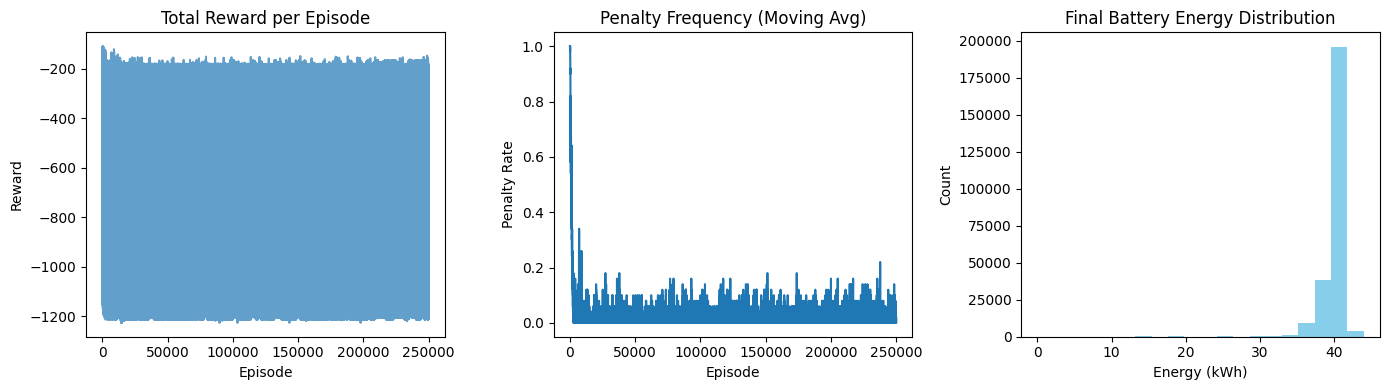

In [5]:
agent.plot_training()

In [6]:
agent.summary(env)

=== Q-Learning Agent Summary ===
Episodes: 250000
Success Rate: 97.13%
Avg Reward: -236.22
Avg Penalty: 0.03

Final Episode Actions (Charging Power):
  Step 1: 22.00 kW
  Step 2: 22.00 kW
  Step 3: 16.50 kW
  Step 4: 22.00 kW
  Step 5: 22.00 kW
  Step 6: 16.50 kW
  Step 7: 22.00 kW
  Step 8: 22.00 kW


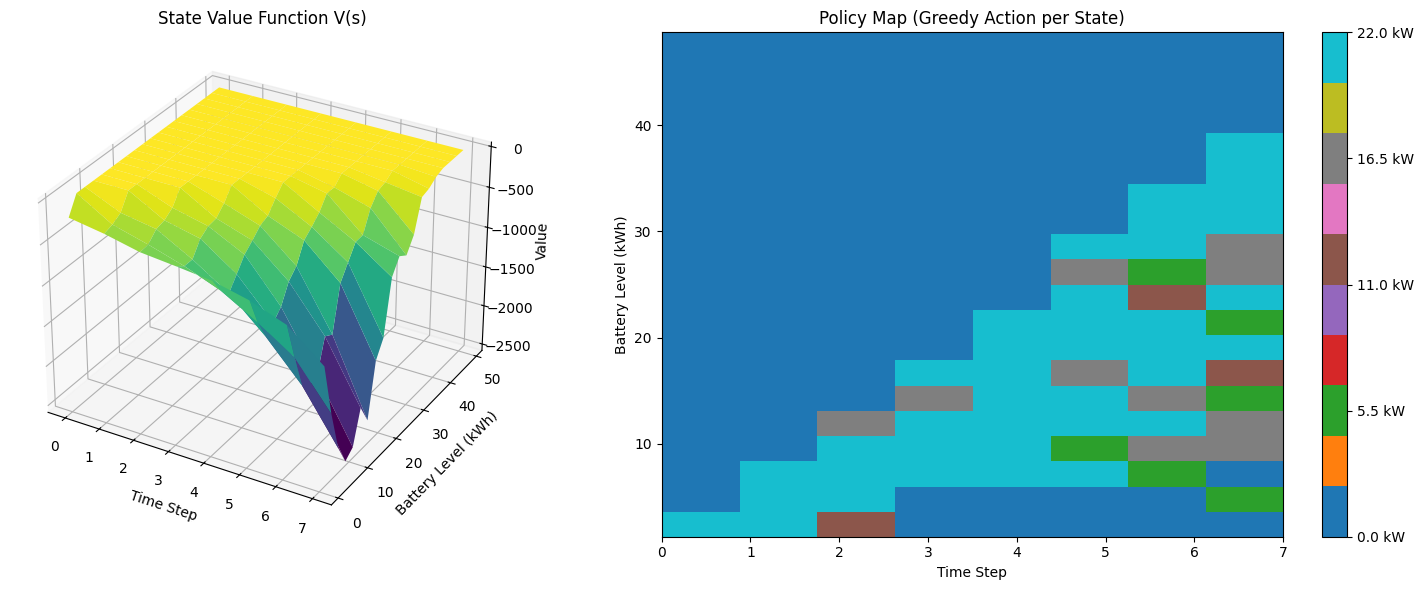

In [7]:
agent.plot_value_and_policy(env)

In [8]:
class DoubleQLearningAgent:
    def __init__(self, env, energy_bins=20, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.energy_bins = energy_bins

        self.energy_bin_edges = np.linspace(0, env.E_max, energy_bins + 1)
        self.num_time_steps = env.num_steps
        self.num_actions = env.action_space.n

        # Initialize two Q-tables
        self.Q1 = np.zeros((self.num_time_steps, energy_bins, self.num_actions))
        self.Q2 = np.zeros_like(self.Q1)

        # Tracking
        self.episode_rewards = []
        self.episode_penalties = []
        self.episode_success_flags = []
        self.episode_end_energy = []
        self.final_action_sequences = []

    def discretize_state(self, state):
        t, E = state
        t = int(t)
        e_bin = np.digitize(E, self.energy_bin_edges) - 1
        e_bin = min(max(e_bin, 0), self.energy_bins - 1)
        return t, e_bin

    def choose_action(self, t, e_bin):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        # Use combined Q-values for action selection
        q_total = self.Q1[t, e_bin] + self.Q2[t, e_bin]
        return np.argmax(q_total)

    def train(self, episodes=1000):
        for ep in range(episodes):
            state = self.env.reset()
            t, e = self.discretize_state(state)
            done = False
            total_reward = 0
            actions_taken = []
            penalty_applied = 0.0
            success = 0

            while not done:
                action = self.choose_action(t, e)
                actions_taken.append(action)

                next_state, reward, done, _ = self.env.step(action)
                t_next, e_next = self.discretize_state(next_state)

                if done and reward < -self.env.fail_penalty / 2:
                    penalty_applied = self.env.fail_penalty
                elif done:
                    success = 1

                # Randomly choose which Q-table to update
                if np.random.rand() < 0.5:
                    a_next = np.argmax(self.Q1[t_next, e_next])
                    td_target = reward + self.gamma * self.Q2[t_next, e_next, a_next]
                    td_error = td_target - self.Q1[t, e, action]
                    self.Q1[t, e, action] += self.alpha * td_error
                else:
                    a_next = np.argmax(self.Q2[t_next, e_next])
                    td_target = reward + self.gamma * self.Q1[t_next, e_next, a_next]
                    td_error = td_target - self.Q2[t, e, action]
                    self.Q2[t, e, action] += self.alpha * td_error

                t, e = t_next, e_next
                total_reward += reward

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            # Logging
            self.episode_rewards.append(total_reward)
            self.episode_penalties.append(penalty_applied > 0)
            self.episode_success_flags.append(success)
            self.episode_end_energy.append(self.env.state[1])
            self.final_action_sequences.append(actions_taken)

            if ep % 50000 == 0:
                print(f"Ep {ep} | Reward: {total_reward:.1f} | Penalty: {penalty_applied} | Success: {success}")

    def get_combined_Q(self):
        return 0.5 * (self.Q1 + self.Q2)

    def summary(self, env=None):
        print("=== Double Q-Learning Summary ===")
        print(f"Episodes: {len(self.episode_rewards)}")
        print(f"Success Rate: {100 * np.mean(self.episode_success_flags):.2f}%")
        print(f"Avg Reward: {np.mean(self.episode_rewards):.2f}")
        print(f"Avg Penalty Rate: {np.mean(self.episode_penalties):.2f}")
        print()
        if env:
            last_actions = self.final_action_sequences[-1]
            power_values = [env.power_levels[a] for a in last_actions]
            print("Final Episode Actions (Charging Power):")
            for i, p in enumerate(power_values):
                print(f"  Step {i+1}: {p:.2f} kW")

    def plot_training(self):
        episodes = np.arange(len(self.episode_rewards))

        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.plot(episodes, self.episode_rewards, alpha=0.7)
        plt.title("Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        plt.subplot(1, 3, 2)
        penalty_rate = np.convolve(self.episode_penalties, np.ones(50)/50, mode='valid')
        plt.plot(np.arange(len(penalty_rate)), penalty_rate)
        plt.title("Penalty Frequency (Moving Avg)")
        plt.xlabel("Episode")
        plt.ylabel("Penalty Rate")

        plt.subplot(1, 3, 3)
        plt.hist(self.episode_end_energy, bins=20, color='skyblue')
        plt.title("Final Battery Energy Distribution")
        plt.xlabel("Energy (kWh)")
        plt.ylabel("Count")

        plt.tight_layout()
        plt.show()


    def plot_3d_values_and_policy(self, env):
        Q_combined = self.get_combined_Q()
        V = np.max(Q_combined, axis=2)
        policy = np.argmax(Q_combined, axis=2)

        energy_bin_centers = 0.5 * (self.energy_bin_edges[:-1] + self.energy_bin_edges[1:])
        time_steps = np.arange(self.num_time_steps)
        T, E = np.meshgrid(time_steps, energy_bin_centers)

        fig = plt.figure(figsize=(16, 6))

        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot_surface(T, E, V.T, cmap='viridis')
        ax1.set_title('Double Q: State Value Function V(s)')
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Battery Level (kWh)')
        ax1.set_zlabel('Value')

        ax2 = fig.add_subplot(1, 2, 2)
        policy_img = ax2.imshow(policy.T, aspect='auto', cmap='tab10',
                                extent=[0, self.num_time_steps - 1,
                                        energy_bin_centers[0], energy_bin_centers[-1]],
                                origin='lower')

        cbar = fig.colorbar(policy_img, ax=ax2, ticks=range(env.num_bins))
        cbar.ax.set_yticklabels([f"{p:.1f} kW" for p in env.power_levels])
        ax2.set_title('Double Q Policy (Greedy Action)')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Battery Level (kWh)')

        plt.tight_layout()
        plt.show()


In [10]:
env = SmartChargeEnv(num_bins=5)
agent = DoubleQLearningAgent(env, energy_bins=5)
agent.train(episodes=250000)

Ep 0 | Reward: -1030.1 | Penalty: 1000.0 | Success: 0
Ep 50000 | Reward: -213.8 | Penalty: 0.0 | Success: 1
Ep 100000 | Reward: -212.9 | Penalty: 0.0 | Success: 1
Ep 150000 | Reward: -213.2 | Penalty: 0.0 | Success: 1
Ep 200000 | Reward: -166.3 | Penalty: 0.0 | Success: 1


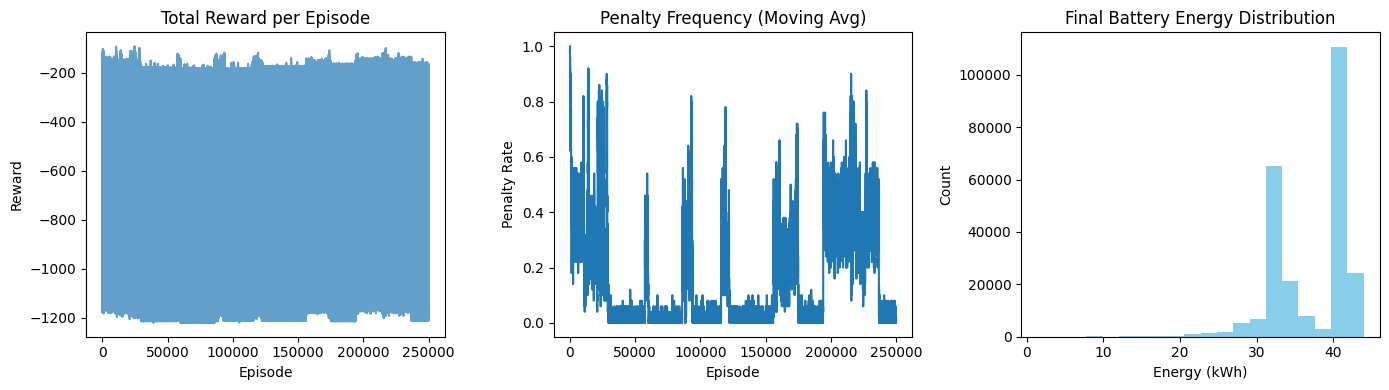

In [11]:
agent.plot_training()

In [12]:
agent.summary(env)

=== Double Q-Learning Summary ===
Episodes: 250000
Success Rate: 84.00%
Avg Reward: -353.68
Avg Penalty Rate: 0.16

Final Episode Actions (Charging Power):
  Step 1: 22.00 kW
  Step 2: 16.50 kW
  Step 3: 22.00 kW
  Step 4: 22.00 kW
  Step 5: 22.00 kW
  Step 6: 22.00 kW
  Step 7: 16.50 kW
  Step 8: 22.00 kW


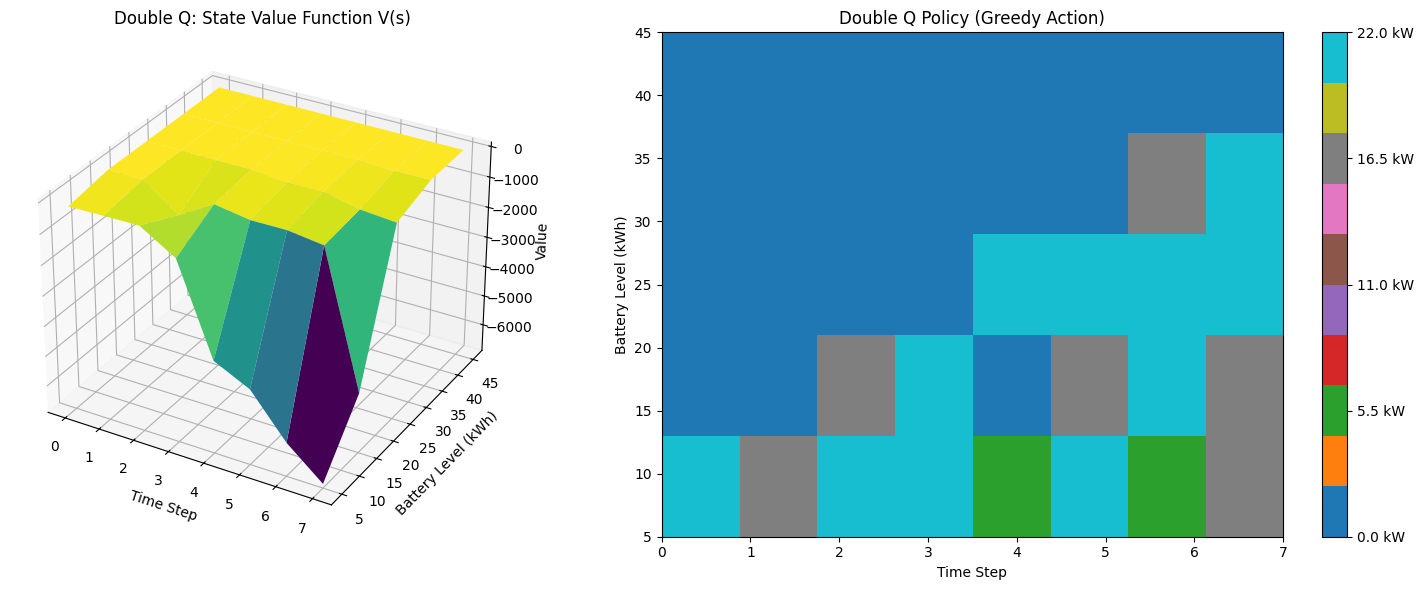

In [13]:
agent.plot_3d_values_and_policy(env)